In [59]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import seaborn as sns
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from random import random

In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
np.random.seed(0)
sample_playlists = np.random.choice(playlists, 500, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 33226
Number of Artists: 6723


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
!!!,1,1
047,1,1
10 Years,1,1
10cc,1,1
112,1,1
...,...,...
David Grisman,289,1
Jethro Tull,323,4
Neil Young,371,4


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=5].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 277


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
53146,0921245fb4097477109ed35ca4d684e4,Various Artists,Tarbolton,Fiddle Favourites
85480,424678a7d04868568c9f95863a901d88,Robin Thicke,Blurred Lines,heartlifting
85483,424678a7d04868568c9f95863a901d88,Katy Perry,Firework,heartlifting
85484,424678a7d04868568c9f95863a901d88,Daft Punk,Get Lucky - Radio Edit,heartlifting
85487,424678a7d04868568c9f95863a901d88,Kylie Minogue,I Believe In You,heartlifting
...,...,...,...,...
12847328,0688129605772a40d2a8211fdb425e55,Beastie Boys,To All The Girls,What Made Me Funky
12847329,0688129605772a40d2a8211fdb425e55,Stevie Wonder,Too High,What Made Me Funky
12847336,0688129605772a40d2a8211fdb425e55,Parliament,Up For The Down Stroke,What Made Me Funky
12847347,0688129605772a40d2a8211fdb425e55,Prince,When Doves Cry,What Made Me Funky


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2

,user_id,artistname,trackname,playlistname
85480,424678a7d04868568c9f95863a901d88,Robin Thicke,Blurred Lines,heartlifting
85483,424678a7d04868568c9f95863a901d88,Katy Perry,Firework,heartlifting
85484,424678a7d04868568c9f95863a901d88,Daft Punk,Get Lucky - Radio Edit,heartlifting
85487,424678a7d04868568c9f95863a901d88,Kylie Minogue,I Believe In You,heartlifting
85488,424678a7d04868568c9f95863a901d88,Phoenix,If I ever feel better,heartlifting
...,...,...,...,...
12847328,0688129605772a40d2a8211fdb425e55,Beastie Boys,To All The Girls,What Made Me Funky
12847329,0688129605772a40d2a8211fdb425e55,Stevie Wonder,Too High,What Made Me Funky
12847336,0688129605772a40d2a8211fdb425e55,Parliament,Up For The Down Stroke,What Made Me Funky
12847347,0688129605772a40d2a8211fdb425e55,Prince,When Doves Cry,What Made Me Funky


In [12]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play


,artistname,playlistname
0,!!!,1
1,047,1
2,10 Ft. Ganja Plant,1
3,10 Years,1
4,10cc,1
...,...,...
6717,李尤 (Li You),1
6718,童安格,1
6719,袁惟仁,1
6720,費玉清,1


[Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Top 10 artist frequencies')]

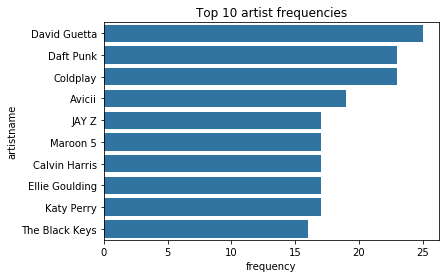

In [13]:
top_10 = unq_play.sort_values(by = 'playlistname', ascending = False)[:10]
f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(y="artistname", x="playlistname", data=top_10, orient = 'h', color = '#1f77b4')
ax.set(xlabel = 'frequency', title = 'Top 10 artist frequencies')

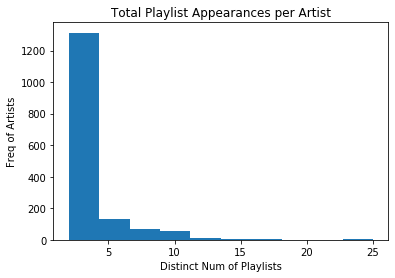

In [14]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=10)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [15]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [16]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 152 ms, sys: 4.42 ms, total: 157 ms
Wall time: 156 ms


In [17]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 464 ms, sys: 48.7 ms, total: 513 ms
Wall time: 292 ms


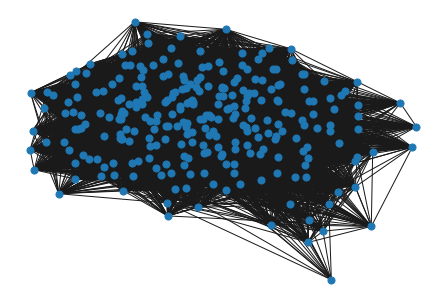

In [18]:
%%time
nx.draw(G, node_size=50)


In [19]:
# # [n for n in G.neighbors]
# neighbors = []
# for i in G.nodes:
#     count = 0
#     for k in G.neighbors(i):
#         count += 1
#     neighbors.append(count)
# neigh_df = pd.DataFrame(G.nodes)
# neigh_df['neighbors'] = neighbors
# neigh_df
# plt.hist(neigh_df['neighbors'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Node Count')
# plt.title('Node Freq of Neighbor Count')
# plt.savefig('node_freq')

In [20]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Justin Timberlake' in i:
        weight_dict[i] = node_weights[i]

In [21]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Maroon 5', 'Justin Timberlake'), 7),
 (('Justin Timberlake', 'JAY Z'), 7),
 (('Justin Timberlake', 'Katy Perry'), 6),
 (('Justin Timberlake', 'P!nk'), 6),
 (('Beyoncé', 'Justin Timberlake'), 5),
 (('Pitbull', 'Justin Timberlake'), 5),
 (('Rihanna', 'Justin Timberlake'), 5),
 (('Justin Timberlake', 'The Black Keys'), 5),
 (('Justin Timberlake', 'Miike Snow'), 5),
 (('Justin Timberlake', 'Passenger'), 5),
 (('Justin Timberlake', 'Ed Sheeran'), 5),
 (('Justin Timberlake', 'Britney Spears'), 5),
 (('Justin Timberlake', 'Daft Punk'), 5),
 (('Justin Timberlake', 'Fun.'), 5),
 (('Justin Timberlake', 'Coldplay'), 5),
 (('Justin Timberlake', 'Gorillaz'), 5),
 (('Justin Timberlake', 'Kanye West'), 5),
 (('Justin Timberlake', 'Drake'), 5),
 (('Shakira', 'Justin Timberlake'), 4),
 (('Justin Timberlake', 'Phoenix'), 4),
 (('Justin Timberlake', 'Foster The People'), 4),
 (('Justin Timberlake', 'Lana Del Rey'), 4),
 (('Justin Timberlake', 'Carly Rae Jepsen'), 4),
 (('Justin Timberlake', 'David Gu

In [22]:
len(G.nodes)

277

In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [24]:
genres = get_artist_genres(list(G.nodes))

In [25]:
df2[df2['artistname']=='Phoenix']

,user_id,artistname,trackname,playlistname
85488,424678a7d04868568c9f95863a901d88,Phoenix,If I ever feel better,heartlifting
937729,79c900d50f847451c38c9dcc328f74a6,Phoenix,Lisztomania,"New Year's Eve, Or, You Forgot What You Meant ..."
4665563,005241c63412ee4be1955b05faf301dc,Phoenix,If I ever feel better,Gosts 'n Stuff
5427717,cb464738d626baae611fc49584b44003,Phoenix,1901,kawaii
5427778,cb464738d626baae611fc49584b44003,Phoenix,Fences,kawaii
5427840,cb464738d626baae611fc49584b44003,Phoenix,Lisztomania,kawaii
6927306,f21063758c53d4812a9ba89958bc4d61,Phoenix,Lisztomania,VPB
9969461,9ccb672668dd60a1a8eb72303476687e,Phoenix,1901,boyhood soundtrack
10300804,8f0796ba6cb8b1fe4d8d69847c6a2a90,Phoenix,1901,/* End of Week */
10503755,bd18a55339aa49e842dd55af9d30487d,Phoenix,Too young,loreley playlist


In [26]:
# implement algorithm
def standardize_matrix(A):
    max_edge = 0
    for i in nx.to_numpy_array(G):
        if (max(i)) > max_edge:
            max_edge = max(i)
    stand_A = []
    for row in nx.to_numpy_array(G):
        stand_row = []
        for edge in row:
            stand_row.append(edge/max_edge)
        stand_A.append(stand_row)
    return np.array(stand_A)


In [52]:
## algorithm work

def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad
    

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
    return F, log_likelihood(F, A)


In [60]:
def bigclam(A, X, K, alpha):
    """
    BigCLAM algorithm for community detection with node features and prior.
    A: adjacency matrix of the graph
    X: node feature matrix
    K: number of communities
    alpha: parameter for the prior probability
    """
    N = A.shape[0] # number of nodes
    F = X.shape[1] # number of features

    # initialize community assignments and feature matrices
    c = np.random.randint(0, K, N)
    mu = np.random.rand(K, F)
    sigma = np.random.rand(K, F)
    count = 0
    max_iter = 100
    # E-step
    while True:
        # compute the prior probability
        prior = np.zeros((N, K))
        for k in range(K):
            mask = (c == k)
            prior[:, k] = np.sum(A[:, mask], axis=1) * alpha
        # compute the likelihood
        likelihood = np.zeros((N, K))
        for k in range(K):
            likelihood[:, k] = multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
        # compute the total probability
        probability = likelihood * prior
        probability /= np.sum(probability, axis=1, keepdims=True)

        # check for convergence
        new_c = np.argmax(probability, axis=1)
        if np.array_equal(new_c, c):
            break
        c = new_c
        if count == max_iter:
            break
        count +=1
    return c

In [61]:
A = nx.to_numpy_array(G)
A = standardize_matrix(A)

attr_mat = np.array([np.random.rand(3) for node in G.nodes()])
bigclam(A, attr_mat, 3, .05)


array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [39]:
# perform bigclam algorithm
start = time.time()
F, ll = train(A, 5) # 3 is number of groups
pred = np.argmax(F, 1)
end = time.time()
print(end - start)

46.67382287979126


In [40]:
nodes = [node for node in G]
nodes_pred = dict(zip(nodes, pred))


In [41]:
# calc percent of top edges are in the same group
dict_nodes_edg_grp = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in nodes:
    dict_nodes_edg_grp[i] = []
    weight_dict = {}
    for j in node_weights:
        if i in j:
            weight_dict[j] = (node_weights[j], [nodes_pred[j[0]], nodes_pred[j[0]]])
    weight_dict = sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)
    dict_nodes_edg_grp[i].append(weight_dict[:3])


In [45]:
sorted(nodes_pred.items(), key=lambda x:x[1], reverse=True)

[('Fall Out Boy', 4),
 ('Azure Ray', 4),
 ('The Killers', 4),
 ('Romeo Santos', 4),
 ('OneRepublic', 4),
 ('Prince Royce', 4),
 ('R.E.M.', 4),
 ('Ed Sheeran', 4),
 ('Naughty Boy', 4),
 ('Arcade Fire', 4),
 ('Mr. Probz', 4),
 ('Miley Cyrus', 4),
 ('The Cure', 4),
 ('M83', 4),
 ('Chromatics', 4),
 ('The Police', 4),
 ('Alice In Chains', 4),
 ('Beastie Boys', 4),
 ('Blur', 4),
 ('Cake', 4),
 ('The Ting Tings', 4),
 ('Disclosure', 4),
 ('Kings Of Convenience', 4),
 ('The Naked And Famous', 4),
 ('Moby', 4),
 ('Lupe Fiasco', 4),
 ('Diddy', 4),
 ('Bad Meets Evil', 4),
 ('Lil Wayne', 4),
 ('Sia', 4),
 ('Yeah Yeah Yeahs', 4),
 ('Icona Pop', 4),
 ('Wiz Khalifa', 4),
 ('OutKast', 4),
 ('deadmau5', 4),
 ('One Direction', 4),
 ('Kelly Clarkson', 4),
 ('Santigold', 4),
 ('Labrinth', 4),
 ('DJ Khaled', 4),
 ('Incubus', 4),
 ('Bloc Party', 3),
 ('Martin Garrix', 3),
 ('Jason Derulo', 3),
 ('Passenger', 3),
 ('Van Halen', 3),
 ('Fatboy Slim', 3),
 ('Skrillex', 3),
 ('Steve Aoki', 3),
 ('Dr. Dre', 3),


In [46]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Daft Punk' in i:
        weight_dict[i] = (node_weights[i], [nodes_pred[i[0]], nodes_pred[i[1]]])
        

In [47]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Daft Punk', 'Katy Perry'), (10, [0, 0])),
 (('Daft Punk', 'JAY Z'), (9, [0, 0])),
 (('Daft Punk', 'Coldplay'), (9, [0, 0])),
 (('Daft Punk', 'Kanye West'), (8, [0, 1])),
 (('Daft Punk', 'David Guetta'), (8, [0, 0])),
 (('Daft Punk', 'Drake'), (7, [0, 1])),
 (('Maroon 5', 'Daft Punk'), (7, [0, 0])),
 (('Rihanna', 'Daft Punk'), (7, [0, 0])),
 (('Daft Punk', 'Madonna'), (7, [0, 0])),
 (('Daft Punk', 'The Black Eyed Peas'), (7, [0, 0])),
 (('Daft Punk', 'Imagine Dragons'), (7, [0, 0])),
 (('Daft Punk', 'P!nk'), (6, [0, 1])),
 (('Daft Punk', 'Linkin Park'), (6, [0, 1])),
 (('Pitbull', 'Daft Punk'), (6, [0, 0])),
 (('Daft Punk', 'Queen'), (6, [0, 0])),
 (('Daft Punk', 'Britney Spears'), (6, [0, 0])),
 (('Daft Punk', 'Michael Jackson'), (6, [0, 0])),
 (('Daft Punk', 'Eminem'), (6, [0, 0])),
 (('Daft Punk', 'Usher'), (6, [0, 0])),
 (('Daft Punk', 'Santigold'), (5, [0, 4])),
 (('Daft Punk', 'Lil Wayne'), (5, [0, 4])),
 (('Daft Punk', 'Ed Sheeran'), (5, [0, 4])),
 (('Daft Punk', 'Jason Derul

In [ ]:
# Node attributes

In [234]:
df2
# avg songs per playlist
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))), 'trackname':'count'})
x['trackname'] / x['playlistname']


artistname
Alesso             1.600000
Avicii             2.571429
Banks              1.500000
Britney Spears     1.333333
Calvin Harris      2.307692
                     ...   
Trey Songz         1.000000
Wiz Khalifa        1.333333
Yeah Yeah Yeahs    1.400000
deadmau5           3.714286
will.i.am          1.600000
Length: 68, dtype: float64

In [235]:
# total songs
x = df2.groupby('artistname').agg({'trackname':'count'})
x


,trackname
artistname,
Alesso,8
Avicii,18
Banks,9
Britney Spears,8
Calvin Harris,30
...,...
Trey Songz,5
Wiz Khalifa,8
Yeah Yeah Yeahs,7


In [236]:
# song variety - closer to 1: unique song on every playlist, closer to 0: many songs in common over playlists
x = df2.groupby('artistname').agg({'trackname':lambda x: len(np.unique(np.array(list(x)))), 'playlistname':'count'})
(x['trackname'] / x['playlistname']).sort_values()


artistname
Imagine Dragons    0.5
Fun.               0.5
Coldplay           0.5
Lana Del Rey       0.5
OneRepublic        0.5
                  ... 
Incubus            1.0
Fleetwood Mac      1.0
Hot Chip           1.0
The xx             1.0
Depeche Mode       1.0
Length: 68, dtype: float64

In [237]:
# playlist appearances
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x))))})
x.sort_values(by='playlistname')


,playlistname
artistname,
Fall Out Boy,3
Fleetwood Mac,3
Michael Jackson,3
Passion Pit,4
Metronomy,4
...,...
Pitbull,9
Coldplay,10
David Guetta,11


In [238]:
x.mean() 


playlistname    5.882353
dtype: float64